In [85]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

label = "good_buy"
min_pct_change = 0
prediction_periods = 1
product_ids = ["VOO"]

In [86]:
def get_df_fear_greed_index():
    print("Retrieving historical fear and greed index")
    import json

    with open("cnn_fear_greed_index_data.json") as f:
        cnn_fear_greed_index_data = json.load(f)

    # df_fear_greed_index = pd.DataFrame(get_historical_cnn_fear_greed_index()["data"])
    # df_fear_greed_index.set_index(
    #     pd.DatetimeIndex([pd.Timestamp(int(x) / 1000, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
    #     inplace=True,
    # )
    df_fear_greed_index = pd.DataFrame(
        data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
    )
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="2y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]])
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    # def get_strategy_length(x):
    #     return x * 1

    # for column in ["close", "fear_greed_index"]:
    #     for days in [7, 14, 30, 60, 90, 120]:
    #         periods = get_strategy_length(days)
    #         df_history[f"{column}_previous"] = df_history[column].shift(1)
    #         df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
    #         df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
    #         df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
    #         df_history[f"{column}_gradient_min_{days}"] = (
    #             df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
    #         )
    #         df_history[f"{column}_gradient_max_{days}"] = (
    #             df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
    #         )

    # df_history.ta.strategy("momentum", length=get_strategy_length(14))
    # df_history.ta.strategy("volatility", length=get_strategy_length(14))
    # # df_history.ta.strategy("momentum", close="fear_greed_index", length=get_strategy_length(14))
    # # df_history.ta.strategy("volatility", close="fear_greed_index", length=get_strategy_length(14))

    # CustomStrategy = ta.Strategy(
    #     name="Momo and Volatility",
    #     ta=[
    #         {"kind": "sma", "length": get_strategy_length(10)},
    #         {"kind": "sma", "length": get_strategy_length(20)},
    #         {"kind": "sma", "length": get_strategy_length(50)},
    #         {"kind": "bbands", "length": get_strategy_length(20)},
    #         {"kind": "rsi", "length": get_strategy_length(14)},
    #         {
    #             "kind": "macd",
    #             "fast": get_strategy_length(8),
    #             "slow": get_strategy_length(21),
    #         },
    #         {
    #             "kind": "sma",
    #             "close": "volume",
    #             "length": get_strategy_length(10),
    #             "prefix": "VOLUME",
    #         },
    #         {
    #             "kind": "sma",
    #             "close": "volume",
    #             "length": get_strategy_length(20),
    #             "prefix": "VOLUME",
    #         },
    #         {
    #             "kind": "sma",
    #             "close": "volume",
    #             "length": get_strategy_length(50),
    #             "prefix": "VOLUME",
    #         },
    #         {"kind": "sma", "close": "fear_greed_index", "length": get_strategy_length(10)},
    #         {"kind": "sma", "close": "fear_greed_index", "length": get_strategy_length(20)},
    #         {"kind": "sma", "close": "fear_greed_index", "length": get_strategy_length(50)},
    #         {"kind": "bbands", "close": "fear_greed_index", "length": get_strategy_length(20)},
    #         {"kind": "rsi", "close": "fear_greed_index", "length": get_strategy_length(14)},
    #         {
    #             "kind": "macd",
    #             "close": "fear_greed_index",
    #             "fast": get_strategy_length(8),
    #             "slow": get_strategy_length(21),
    #         },
    #     ],
    # )
    # df_history.ta.strategy(CustomStrategy)

    df_history[label] = (
        (
            (df_history[::-1].close.rolling(window=prediction_periods, min_periods=1).max().shift(1) - df_history.close)
            / df_history.close
            * 100
        )
        > min_pct_change
    ).astype(int)
    print(f"Total good buy opportunities: {(df_history[label]).value_counts(normalize=True)[1]*100:.2f}%")
    df_history = df_history.dropna(axis=1, thresh=len(df_history) * 0.9).dropna()
    return df_history


df_fear_greed_index = get_df_fear_greed_index()
history_dfs = {}

for product_id in product_ids:
    history_dfs[product_id] = get_df_history(product_id)

Retrieving historical fear and greed index
Retrieving historical data for VOO
Total good buy opportunities: 34.44%


In [3]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# total_products = len(history_dfs)
# df_period = history_dfs[product_id]
# pd.DataFrame(scaler.fit_transform(df_period.values), index=df_period.index, columns=df_period.columns)[["close", "fear_greed_index"]].plot(figsize=(10, 3 * total_products))
# history_dfs[product_id]

In [93]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, roc_auc_score
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

final_dfs = {}

for product_id in product_ids:
    print(f"Computing backtest data frame for {product_id}")
    df_history = history_dfs[product_id]
    backtest_timestamps = [pd.to_datetime(x, utc=True) for x in df_history.index.values]
    used_backtest_timestamps = []
    total_timestamps = len(backtest_timestamps)
    timestamp_num = 0
    y_pred = []
    train_min_days = 90
    feature_columns = [x for x in df_history.columns if x != label]

    for x in backtest_timestamps:
        timestamp_num += 1

        if timestamp_num % 10 == 0 or timestamp_num == total_timestamps:
            print(
                f"{timestamp_num}/{total_timestamps} -- {timestamp_num/total_timestamps*100:.0f}%",
                end="\r",
            )

        df_period = df_history.loc[
            (df_history.index >= (x - timedelta(days=train_min_days))) & (df_history.index <= x)
        ].copy()
        df_period[label] = (
            (
                (
                    df_period[::-1].close.rolling(window=prediction_periods, min_periods=1).max().shift(1)
                    - df_period.close
                )
                / df_period.close
                * 100
            )
            > min_pct_change
        ).astype(int)
        # df_period.fillna(0, inplace=True)
        df_period.dropna(inplace=True)

        if len(df_period) >= (train_min_days):
            scaler = MinMaxScaler(feature_range=(0, 1))
            df_period = pd.DataFrame(
                scaler.fit_transform(df_period.values), index=df_period.index, columns=df_period.columns
            )
            df_train = df_period.loc[df_period.index < x]
            df_test = df_period.loc[df_period.index >= x]

            X_train = np.array(df_train[feature_columns])
            X_test = np.array(df_test[feature_columns])[:1]
            y_train = np.array(df_train[label])

            fs = SelectKBest(k="all")
            fs.fit(X_train, y_train)
            X_train_fs = fs.transform(X_train)
            X_test_fs = fs.transform(X_test)

            # model = SVC(probability=True)
            # model = GaussianNB()
            model = DecisionTreeClassifier()
            model.fit(X_train_fs, y_train)

            # pred_value = model.predict(X_test_fs)[0]
            pred_value = model.predict_proba(X_test_fs)[0][1]
            # X_y_test = X_test.copy()
            # X_y_test = np.append(X_y_test, [model.predict_proba(X_test_fs)[0][1]])
            # pred_value = scaler.inverse_transform(X_y_test.reshape(1, -1))[0][-1]

            used_backtest_timestamps.append(x)
            y_pred.append(pred_value)

    df_backtest = pd.DataFrame({f"{label}_pred": y_pred})
    df_backtest.set_index(pd.DatetimeIndex(used_backtest_timestamps), inplace=True)
    df_final = df_history.join(df_backtest, how="inner")[:-1]

    y_true = df_final[label].values
    y_pred = [1 if x > 0.9 else 0 for x in df_final[f"{label}_pred"].values]

    print(f"Predicted period F1 score: {f1_score(y_true, y_pred):.2f}")
    print(f"Predicted period precision score: {precision_score(y_true, y_pred):.3f}")
    print(f"Predicted period ROC AUC score: {roc_auc_score(y_true, y_pred):.3f}")

    df_final["product_id"] = product_id
    final_dfs[product_id] = df_final
    print()

Computing backtest data frame for VOO
Predicted period F1 score: 0.26
Predicted period precision score: 0.314
Predicted period ROC AUC score: 0.479



<Axes: >

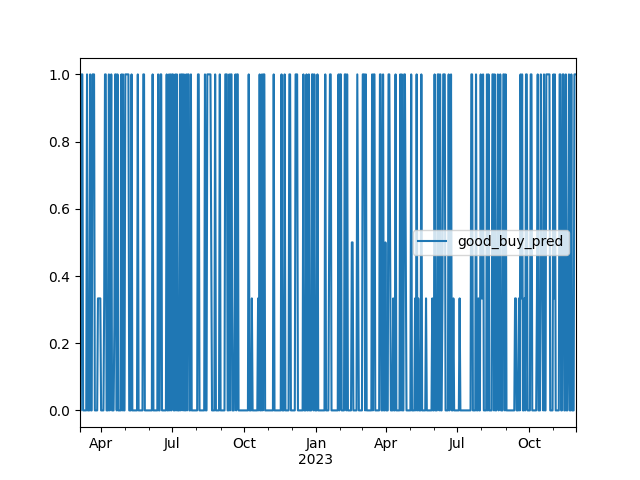

In [89]:
df_final[["good_buy_pred"]].plot()

Total fee percentage: 0%
Total good buy opportunities: 35.22%
Start money: $100
Min purchase amount: $2
Max purchase amount: $2
End money: $99.94
Percentage earned: -0.063%
Total trades: 272
Total volume: $647.94
Total days: 635.0
Avg 30 day volume: $30.61


,product_id,side,amount,coins,money,total_balance
timestamp,,,,,,
2022-03-07 00:00:00+00:00,VOO,buy,2.000000,0.005336,98.000000,100.000000
2022-03-08 00:00:00+00:00,VOO,buy,2.000000,0.010713,96.000000,99.984907
2022-03-09 00:00:00+00:00,VOO,sell,4.091114,0.000000,100.091114,100.091114
2022-03-14 00:00:00+00:00,VOO,buy,2.000000,0.005368,98.091114,100.091114
2022-03-15 00:00:00+00:00,VOO,sell,2.043875,0.000000,100.134989,100.134989
...,...,...,...,...,...,...
2023-11-24 00:00:00+00:00,VOO,buy,2.000000,0.004780,97.922548,99.922548
2023-11-25 00:00:00+00:00,VOO,sell,1.999997,0.000000,99.922545,99.922545
2023-11-28 00:00:00+00:00,VOO,buy,2.000000,0.004784,97.922545,99.922545


,product_id,side,total_orders
0,VOO,buy,162
1,VOO,sell,110


<Axes: xlabel='timestamp'>

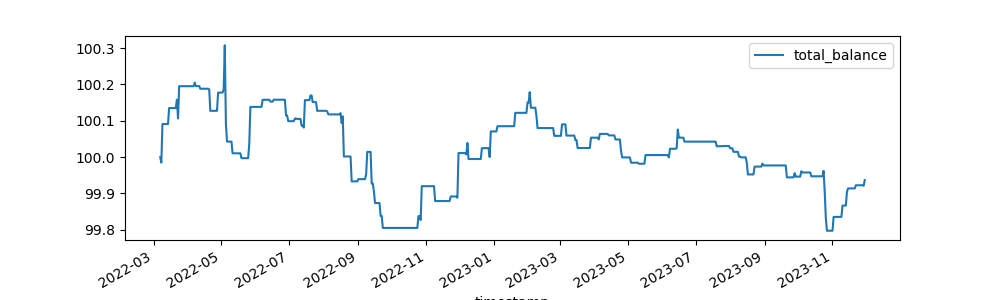

In [91]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")
print(f"Total good buy opportunities: {(df_final[label]).value_counts(normalize=True)[1]*100:.2f}%")

coins = {}
coins_hold = {}
min_hold = 0

for product_id in product_ids:
    coins[product_id] = 0
    coins_hold[product_id] = 0

money = 100
start_money = money
print(f"Start money: ${start_money}")

min_purchase_amount = 2
max_purchase_amount = 2
print(f"Min purchase amount: ${min_purchase_amount}")
print(f"Max purchase amount: ${max_purchase_amount}")

total_trades = 0
total_volume = 0
orders = []

total_products = len(product_ids)
df_final = pd.concat([final_dfs[product_id] for product_id in product_ids]).sort_index()

for index, row in df_final.iterrows():
    product_id = row.product_id
    should_buy = row.good_buy
    should_buy_pred = row.good_buy_pred > 0.5 and pd.to_datetime(index, utc=True) != pd.to_datetime(
        df_final.index.values[-1], utc=True
    )

    final_index = index

    def get_total_balance():
        total_balance = money

        for coin_product_id in product_ids:
            df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == coin_product_id)]

            if len(df_final_product_period) > 0:
                total_balance += coins[coin_product_id] * df_final_product_period.close.values[-1] * p_keep

        return total_balance

    def floor_value(x: float, precision: int):
        return np.true_divide(np.floor(x * 10**precision), 10**precision)

    purchase_amount = floor_value(money / len(product_ids) / 10, 2)
    purchase_amount = purchase_amount if purchase_amount >= min_purchase_amount else min_purchase_amount
    purchase_amount = purchase_amount if purchase_amount <= max_purchase_amount else max_purchase_amount

    if should_buy_pred and money >= purchase_amount:
        money -= purchase_amount
        coins[product_id] += purchase_amount / row.close * p_keep
        coins_hold[product_id] = 0
        total_trades += 1
        total_volume += purchase_amount
        orders.append(
            {
                "timestamp": index,
                "product_id": product_id,
                "side": "buy",
                "amount": purchase_amount,
                "coins": coins[product_id],
                "money": money,
                "total_balance": get_total_balance(),
            }
        )
    elif not should_buy_pred and coins[product_id] > 0 and coins_hold[product_id] >= min_hold:
        condition_factor = 1
        sell_coins = floor_value(coins[product_id] * condition_factor, 8)
        sell_amount = sell_coins * row.close * p_keep
        total_trades += 1
        total_volume += sell_amount
        money += sell_amount
        coins[product_id] = 0
        orders.append(
            {
                "timestamp": index,
                "product_id": product_id,
                "side": "sell",
                "amount": sell_amount,
                "coins": coins[product_id],
                "money": money,
                "total_balance": get_total_balance(),
            }
        )
    else:
        coins_hold[product_id] += 1

money += sum(
    [
        (coins[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
print(f"Percentage earned: {(money - start_money)/start_money*100:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total trades: {total_trades}")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders)

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append(
            {
                "product_id": product_id,
                "side": side,
                "total_orders": len(df_orders_product_side),
                # "avg_value": df_orders_product_side.value.sum() / len(df_orders_product_side)
            }
        )

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)
df_orders[["total_balance"]].plot(figsize=(10, 3))

In [15]:
# display(df_orders.loc[df_orders.side == "buy"].describe())
# display(df_orders.loc[df_orders.side == "sell"].describe())

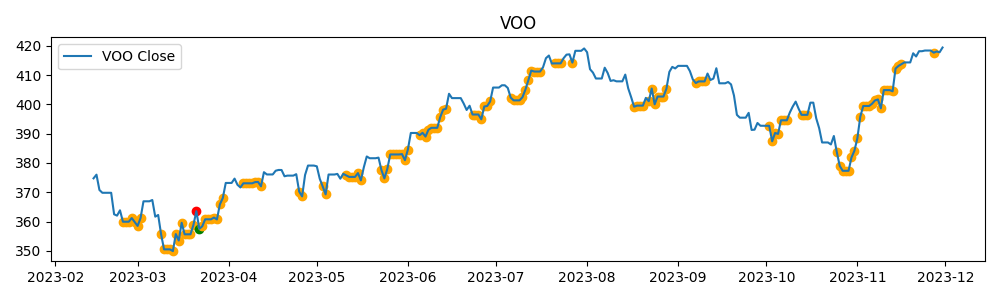

In [72]:
fig, ax = plt.subplots(nrows=total_products, figsize=(10, 3 * total_products))

for product_index, product_id in enumerate(product_ids):
    ax_index = ax if total_products <= 1 else ax[product_index]
    ax_index.plot(final_dfs[product_id][["close"]], label=f"{product_id} Close")
    ax_index.set_title(product_id)

    for index, row in final_dfs[product_id].iterrows():
        product_id = row.product_id
        should_buy = row.good_buy
        should_buy_pred = (row.good_buy_pred > 0.5 and row.fear_greed_index > 40) and pd.to_datetime(
            index, utc=True
        ) != pd.to_datetime(df_final.index.values[-1], utc=True)

        marker_color = None

        if should_buy and should_buy_pred:
            marker_color = "green"
        elif not should_buy and should_buy_pred:
            marker_color = "red"
        elif should_buy and not should_buy_pred:
            marker_color = "orange"

        if marker_color:
            ax_index.scatter(index, row.close, color=marker_color)

plt.legend()
plt.tight_layout()
plt.show()